In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/LLM_experimentations/Essay Scoring Project")

In [26]:
!pip install keras_nlp
!pip install sentence_transformers
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


# Necessary Imports

In [27]:
!pip freeze > requirements.text

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
import keras_tuner
from keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import seaborn as sns
import keras_nlp
import pickle
import keras
import time
import gc
import torch
import tqdm
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="False"

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:

class Config:
    seed = 42  # Random seed
    # List of embedding models
    embedding_models_list = [
        "all-mpnet-base-v2", #following the Hugging-face naming convention
        'Alibaba-NLP/gte-large-en-v1.5'
    ]
    epochs = 50 # Training epochs
    batch_size =8  # Batch size
    test_size = 0.2 #test split ratio
    scheduler = 'cosine'  # Learning rate scheduler
    patience=5 #used for early stopping
    base_path =os.getcwd()
    data_folder = "data"

## 1.Exploratory Data Analysis

## 1.1 Read the Data

In [7]:
#read the data
df_train = pd.read_csv(f"{Config.base_path}/{Config.data_folder}/train.csv")
print(f"We have about {df_train.shape[0]:,} essays")
df_test = pd.read_csv(f"{Config.base_path}/{Config.data_folder}/test.csv")
df_train.head()

We have about 17,307 essays


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## 1.3 Explore the data

What's the score distribution across the essays?

<Axes: xlabel='score', ylabel='count'>

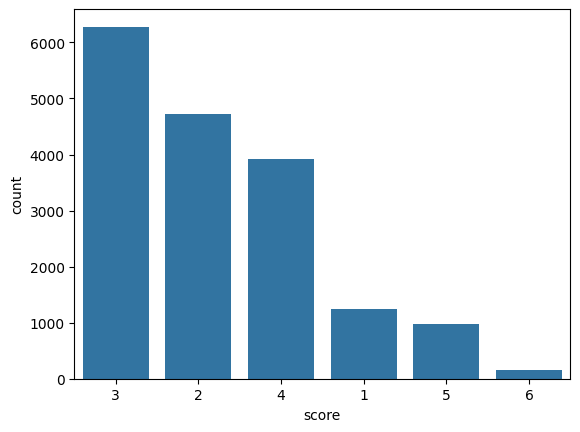

In [8]:
#visualize the score distribution across the essays
sns.countplot(data=df_train,
            x="score",
            order=df_train["score"].value_counts().index)

Is there a correlation between score and essay length or number of words?

<Axes: xlabel='score', ylabel='essay_length'>

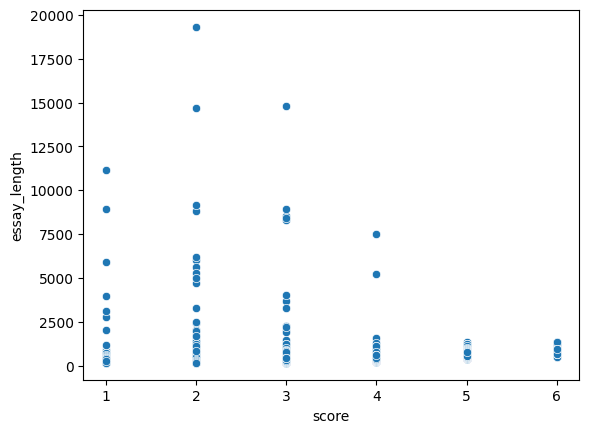

In [9]:
#compute the number of words per essays
df_train["essay_length"] = df_train["full_text"].apply(lambda x:len(x.split(" ")))

#plot the scatter plot

sns.scatterplot(data=df_train,x="score",y="essay_length")

In [10]:
print(f"The Pearson correlation is {np.corrcoef(df_train['essay_length'],df_train['score'])}")

The Pearson correlation is [[1.         0.26840173]
 [0.26840173 1.        ]]


There seems to be **no** relationship between the length of the essay and the score the student gets.

What's the distribution of tokens ?

In [11]:
#load the tokenizer
tokenizer = keras_nlp.models.DebertaV3Tokenizer.from_preset("deberta_v3_base_en")


100%|██████████| 540/540 [00:00<00:00, 736kB/s]


100%|██████████| 424/424 [00:00<00:00, 681kB/s]


100%|██████████| 2.35M/2.35M [00:00<00:00, 5.12MB/s]


<Figure size 1600x1600 with 0 Axes>

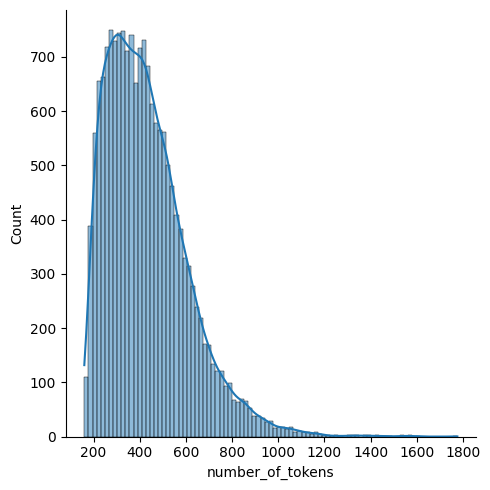

In [12]:
#compute token length of each essay across the dataset
df_train["number_of_tokens"] = df_train["full_text"].apply(lambda x:tokenizer(x).shape[0])

#define a figure object of custom dimensions
plt.figure(figsize=(8,8),dpi=200)

#plot the histogram
sns.displot(data=df_train,x="number_of_tokens",kind="hist",kde=True)

In [13]:
df_train["number_of_tokens"].describe()

,number_of_tokens
count,17307.000000
mean,430.772578
std,176.808736
min,160.000000
25%,296.000000
50%,403.000000
75%,528.000000
max,1776.000000


<Axes: xlabel='score', ylabel='essay_length'>

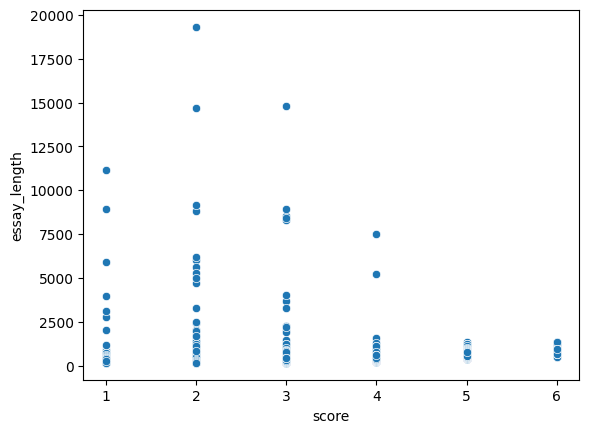

In [14]:
#compute the number of words per essays
df_train["essay_length"] = df_train["full_text"].apply(lambda x:len(x.split(" ")))

#plot the scatter plot

sns.scatterplot(data=df_train,x="score",y="essay_length")

# 2.Prepare the data for training

## 2.1 Generate Embedding of the texts

In [15]:
def embed(arr, model, num_of_gpus=torch.cuda.device_count(), batch_size=5):
    """
    Generates embeddings for the input array using a specified model, with support for multi-GPU processing.

    Parameters:
    -----------
    arr : list or array-like
        The input data to be embedded, typically a list of sentences or data points.

    model : SentenceTransformer or any compatible model
        The model used to generate embeddings. This model must support the `encode` and `encode_multi_process` methods.

    num_of_gpus : int, optional, default=torch.cuda.device_count()
        The number of GPUs available for processing. If more than one GPU is detected,
        multi-GPU encoding will be used. Otherwise, single-GPU encoding will be performed.

    batch_size : int, optional, default=5
        The batch size used for embedding the input data.

    Returns:
    --------
    embeddings : list or numpy.ndarray
        The embeddings generated for the input data. Each element in the output corresponds to the embedding of the respective input item.

    Notes:
    ------
    - If `num_of_gpus` is greater than 1, multi-process encoding is used across the available GPUs.
    - Single-GPU encoding uses the first detected CUDA device (device="cuda").
    - Displays a progress bar when embedding with a single GPU.
    - Prints the time taken for the embedding process in minutes.
    """

    # Start timer
    start_time = time.time()

    # If multiple GPUs are available, use multi-GPU processing
    if num_of_gpus > 1:
        print(f"Multi-GPU mode: {num_of_gpus} GPUs detected. Using multi-process encoding.")
        embeddings = model.encode_multi_process(arr, device=torch.cuda.current_device(), batch_size=batch_size)
    else:
        # Single GPU or CPU processing
        print(f"Single-GPU/CPU mode: Using batch size {batch_size}")
        embeddings = model.encode(arr, batch_size=batch_size, show_progress_bar=True, device="cuda" if torch.cuda.is_available() else "cpu")

    # Calculate and print time taken
    end_time = time.time()
    elapsed_minutes = (end_time - start_time) / 60
    print(f"Embedding completed in {elapsed_minutes:.2f} minutes.")

    return embeddings


In [16]:


def generate_embeddings(df, embedding_models_list=Config.embedding_models_list, num_of_gpus=torch.cuda.device_count()):
    """
    Generates embeddings for a DataFrame using multiple models and appends them together.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the text data. It must have a column named 'full_text'.

    embedding_models_list : list of str, optional, default=embedding_models_list
        A list of model names or paths to pre-trained embedding models.
        The first model in the list is used initially, and subsequent models' embeddings
        are appended to the final embedding.

    num_of_gpus : int, optional, default=torch.cuda.device_count()
        The number of GPUs available for processing. If more than one GPU is detected,
        multi-GPU encoding will be used.

    Returns:
    --------
    final_embedding : numpy.ndarray
        The final embedding matrix where embeddings from all models are concatenated along the last axis.

    Notes:
    ------
    - Each model is loaded one at a time, and its embeddings are computed.
      The embeddings from each model are appended horizontally to form the final embedding matrix.
    - If any model fails, it will print an exception message and continue with the next model.
    - The process prints the total time taken for embedding.
    - After embedding each model, the CUDA cache is cleared and garbage collection is performed to free memory.
    """

    t1 = time.time()  # Start time
    arr = df["full_text"].to_numpy()  # Convert the 'full_text' column to a NumPy array

    # Embed using the first model
    model = SentenceTransformer(embedding_models_list[0], trust_remote_code=True)
    print(f"Embedding using {embedding_models_list[0]} ")
    final_embedding = embed(arr, model, num_of_gpus)  # Generate embeddings using the first model
    del model  # Delete the model to free up memory

    # Clear GPU cache and perform garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    # Loop over the remaining models in the list
    for model_name in tqdm.tqdm(embedding_models_list[1:]):
        print(f"Embedding using {model_name} ")
        try:
            model = SentenceTransformer(model_name, trust_remote_code=True)  # Load the model
            embeddings = embed(arr, model, num_of_gpus)  # Generate embeddings
            del model  # Delete the model after embedding

            # Clear GPU cache and perform garbage collection
            torch.cuda.empty_cache()
            gc.collect()

            # Append the embeddings to the final embedding matrix along the last axis (horizontally)
            final_embedding = np.append(final_embedding, embeddings, axis=1)
        except Exception as e:
            print(f"Exception encountered with model {model_name}: {e}")

    # Print total time taken for embedding
    print(f"Overall process finished... took {(time.time() - t1) / 60:.2f} minutes")

    return final_embedding


In [17]:
#apply the function
final_embedding = generate_embeddings(df_train)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding using all-mpnet-base-v2 
Single-GPU/CPU mode: Using batch size 5


Batches:   0%|          | 0/3462 [00:00<?, ?it/s]

Embedding completed in 7.51 minutes.


  0%|          | 0/1 [00:00<?, ?it/s]

Embedding using Alibaba-NLP/gte-large-en-v1.5 


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Single-GPU/CPU mode: Using batch size 5


Batches:   0%|          | 0/3462 [00:00<?, ?it/s]

Embedding completed in 39.77 minutes.


100%|██████████| 1/1 [40:03<00:00, 2403.62s/it]

Overall process finished... took 47.92 minutes


In [18]:
test_embeddings = generate_embeddings(df_test,num_of_gpus=1)



Embedding using all-mpnet-base-v2 
Single-GPU/CPU mode: Using batch size 5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding completed in 0.00 minutes.


  0%|          | 0/1 [00:00<?, ?it/s]

Embedding using Alibaba-NLP/gte-large-en-v1.5 
Single-GPU/CPU mode: Using batch size 5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding completed in 0.01 minutes.


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

Overall process finished... took 0.08 minutes


In [28]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [29]:
def prepare_data(final_embedding,df_train,Config=Config):
  #build the features and labels
  y = df_train["score"].to_numpy()
  X_train,X_val,y_train,y_val = train_test_split(final_embedding,y, test_size=Config.test_size,random_state=Config.seed,stratify=y)
  y_val = to_ordinal(y_val)
  y_train = to_ordinal(y_train)
  return X_train,X_val,y_train,y_val


In [30]:
X_train,X_val,y_train,y_val = prepare_data(final_embedding,df_train)

In [31]:
def get_lr_callback(batch_size=100, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()


    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(10, plot=False)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)

#buuild the early stopping call back
early_callback = keras.callbacks.EarlyStopping(
    monitor='val_weighted_kappa',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [32]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name = 'o_sum', initializer = 'zeros')
        self.e_sum = self.add_weight(name = 'e_sum', initializer = 'zeros')

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        p = keras.ops.sum(y_true, axis=-1) - 1
        p = keras.ops.cast(p,dtype="int8")
        y_true = keras.ops.one_hot(p, 6, dtype="int8")
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(keras.ops.sum(
            keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
        ))

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)

# 3.Training

In [36]:

#build the DNN
keras.utils.set_random_seed(101)
def build_model(hp):

    model = Sequential()
    for i in range(hp.Int("num_layers",1,10)):
        model.add(
            keras.layers.Dense(
            units=hp.Int(f"units_{i}",min_value=32,max_value=2096,step=32),
            activation="relu",
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.25))
    if hp.Boolean("bacthnormalization"):
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(6,activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    #compile the model

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[WeightedKappa()],
    )
    return model





In [37]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_weighted_kappa", direction="max"),
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [38]:
tuner.search_space_summary()


Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 2096, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
bacthnormalization (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [39]:
tuner.search(X_train, y_train, epochs=Config.epochs, validation_data=(X_val, y_val))

Trial 5 Complete [00h 06m 52s]
val_weighted_kappa: 0.7492246031761169

Best val_weighted_kappa So Far: 0.7578647136688232
Total elapsed time: 00h 23m 12s


In [40]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 992)                 │       1,778,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 640)                 │         635,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 864)                 │         553,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1568)                │       1,356,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 704)                 │       1,104,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 832)                 │         586,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 352)                 │         293,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 352)                 │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           2,118 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,312,198 (24.08 MB)

 Trainable params: 6,311,494 (24.08 MB)

 Non-trainable params: 704 (2.75 KB)

# Test the Model on the validation Set

In [42]:
#test_embeddings = generate_embeddings(df_test,num_of_gpus=1)
test_preds = best_model.predict(test_embeddings, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

# Create a DataFrame to store the submission
sub_df = df_test[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


,essay_id,score
0,000d118,2
1,000fe60,2
2,001ab80,4
